## Interoperability with NetworkX and iGraph
The graph / network analysis libraries [networkx](https://networkx.org/) and [igraph](https://igraph.org/) offer powerful tools for analysing graph data structures. To process pyclesperanto neighborhood adjacency graphs in these libraries, we can convert those matrixes using the two clesperanto functions `to_networkx` and `to_igraph`.

In [1]:
import pyclesperanto_prototype as cle
import igraph
import networkx
from skimage.io import imread, imsave, imshow
import numpy as np
import matplotlib.pyplot as plt

cle.select_device("amd")

<gfx90c on Platform: AMD Accelerated Parallel Processing (2 refs)>

We start by labeling an image...

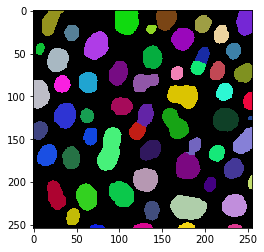

In [2]:
blobs = cle.imread('https://samples.fiji.sc/blobs.png')
labels = cle.voronoi_otsu_labeling(blobs, spot_sigma=4)
cle.imshow(labels, labels=True)

... and visualizing a graph of proximal objects which have a maximum centroid distance of 50 pixels.

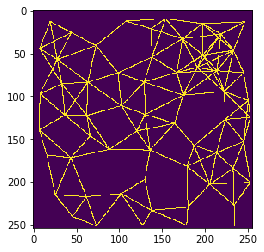

In [3]:
mesh = cle.draw_mesh_between_proximal_labels(labels, maximum_distance=50)
cle.imshow(mesh)

## igraph
We can also retrieve an analogous igraph graph directly from the label image

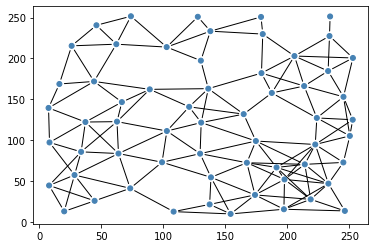

In [4]:
igraph_graph = cle.proximal_labels_to_igraph(labels, maximum_distance=50)

fig, ax = plt.subplots()
igraph.plot(igraph_graph, target=ax)

Note: The visualization is flipped because the origin of the coordinate system is on the bottom left, while in clesperanto it's on the top left, because clesperanto uses community standards from the image processing field.

## networkx
The same also works with networkx.

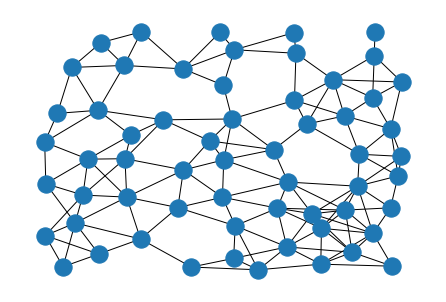

In [5]:
networkx_graph = cle.proximal_labels_to_networkx(labels, maximum_distance=50)

pos = networkx.get_node_attributes(networkx_graph,'pos')

networkx.draw(networkx_graph, pos)

## n-nearest neighbors
We can alternatively also create networks between n-nearest neighbors for all

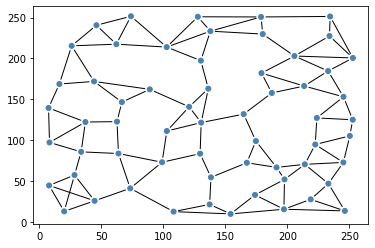

In [6]:
igraph_graph = cle.n_nearest_labels_to_igraph(labels, n=3)

fig, ax = plt.subplots()
igraph.plot(igraph_graph, target=ax)

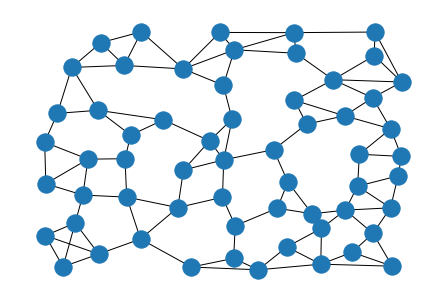

In [7]:
networkx_graph = cle.n_nearest_labels_to_networkx(labels, n=3)

pos = networkx.get_node_attributes(networkx_graph,'pos')

networkx.draw(networkx_graph, pos)

## touching neighbors
Starting from a label image where neighbors touch, we can also generate graphs between those.

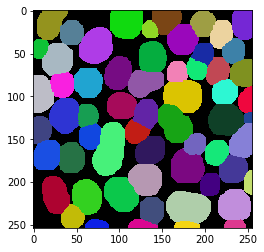

In [8]:
touching_labels = cle.dilate_labels(labels, radius=5)

cle.imshow(touching_labels, labels=True)

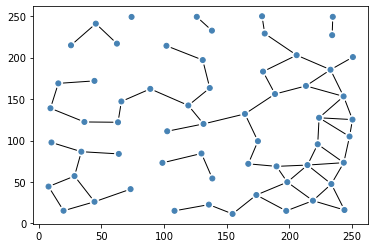

In [9]:
igraph_graph = cle.touching_labels_to_igraph(touching_labels)

fig, ax = plt.subplots()
igraph.plot(igraph_graph, target=ax)

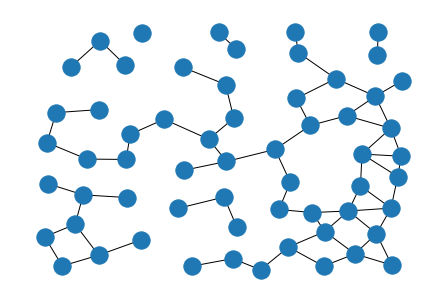

In [10]:
networkx_graph = cle.touching_labels_to_networkx(touching_labels)

pos = networkx.get_node_attributes(networkx_graph,'pos')

networkx.draw(networkx_graph, pos)

# How it works
The process under the hood involves the following steps:

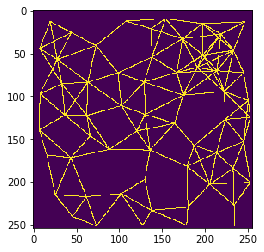

In [11]:
# extract centroid positions
centroids = cle.centroids_of_labels(labels)

# determine a distance matrix
distance_matrix = cle.generate_distance_matrix(centroids, centroids)

# threshold the distance matrix
adjacency_matrix = cle.generate_proximal_neighbors_matrix(distance_matrix, max_distance=50)

# generate a mesh from centroid positions and the adjacency matrix
mesh = cle.touch_matrix_to_mesh(centroids, adjacency_matrix, cle.create_like(blobs))

cle.imshow(mesh)

The key data structure for interoperating with NetworkX and iGraph is the `adjacency_matrix`, a square matrix where all labels are represented on the X and Y axis. If there is a white pixel in this matrix, that means that these two labels are connected in the graph. Note: Also connections to background are part of this matrix, and per definition, no label is _proximal_ to the background, because the centroid of background is not determined. Also important are the `centroids`, an 2D array with positions of the centroids of the labels in 2D or 3D coordinates.

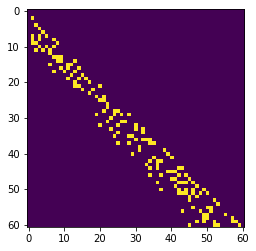

In [12]:
cle.imshow(adjacency_matrix)

In [13]:
print(centroids.shape)

(2, 60)


In [14]:
print(centroids)

[[  8.204301    7.428571    7.868421   16.171547   20.05785    26.06703
   28.38368    33.695366   37.170773   44.579548   44.138954   46.053032
   63.820732   62.62832    62.091503   66.57554    73.30478    73.875
   89.064      98.96631   102.854416  102.69871   108.2901    120.824135
  129.65987   130.25954   127.814156  130.53102   136.27623   137.34653
  137.92424   138.41666   154.26434   167.35979   164.81137   173.93842
  174.6263    178.8       180.18393   179.16243   187.51054   191.2991
  197.25308   197.71729   205.74875   214.09677   213.56598   218.84038
  223.803     222.54053   233.13535   232.89908   234.01593   234.5
  245.199     246.39612   250.42155   252.74074   245.29445   252.89412  ]
 [ 97.4552    139.59091    44.91228   168.83682    13.318181  215.42029
   57.68403    85.983444  122.37931    26.178032  171.96129   240.55682
   83.911446  122.867256  217.44118   146.73741    41.422752  251.5625
  162.28801    73.28      111.41766   213.90817    12.988842  140.9

# NetworkX
The [networkx](https://networkx.org/) library has support for [reading graphs from adjacency matrices](https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_numpy_matrix.html) and for  [drawing graphs](https://networkx.org/documentation/stable/reference/drawing.html#module-networkx.drawing.nx_pylab).

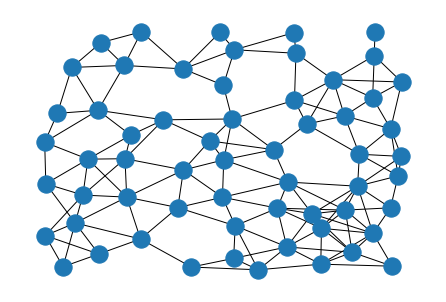

In [15]:
networkx_graph = cle.to_networkx(adjacency_matrix, centroids)

pos = networkx.get_node_attributes(networkx_graph,'pos')

networkx.draw(networkx_graph, pos)

Note: The visualization is flipped because the origin of the coordinate system is on the bottom left, while in clesperanto it's on the top left, because clesperanto uses community standards from the image processing field.

# igraph
The [igraph](https://igraph.org/) library also has support for [converying graphs from adjacency matrices and for [drawing graphs](https://igraph.org/python/tutorial/0.9.7/visualisation.html) 

In [16]:
igraph_graph = cle.to_igraph(adjacency_matrix, centroids)

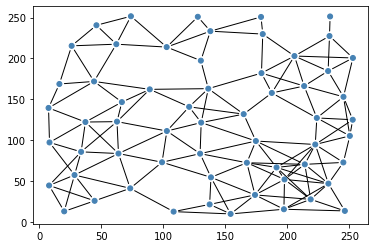

In [17]:
fig, ax = plt.subplots()
igraph.plot(igraph_graph, target=ax)

As you can see, the igraph is directed. To make it direct in both direction along all edges, you can convert the adjacency matrix before passing it to `to_igraph`:

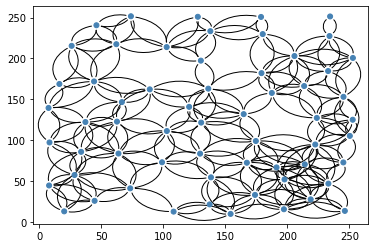

In [18]:
bidirectional_matrix = cle.touch_matrix_to_adjacency_matrix(adjacency_matrix)
cle.set_where_x_equals_y(bidirectional_matrix, 0)

igraph_graph = cle.to_igraph(bidirectional_matrix, centroids)
fig, ax = plt.subplots()
igraph.plot(igraph_graph, target=ax)

# Documentation

In [19]:
print(cle.to_networkx.__doc__)


    Converts a given adjacency matrix to a networkx [1] graph data structure.

    Note: the given centroids typically have one entry less than the adjacency matrix is wide, because
    those matrices contain a first row and column representing background. When exporting the igraph graph,
    that first column will be ignored.

    Parameters
    ----------
    adjacency_matrix : Image
        m*m touch-matrix, proximal-neighbor-matrix or n-nearest-neighbor-matrix
    centroids : Image, optional
        d*(m-1) matrix, position list of centroids

    Returns
    -------
    networkx graph

    See Also
    --------
    ..[1] https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_numpy_matrix.html
    


In [20]:
print(cle.to_igraph.__doc__)


    Converts a given adjacency matrix to a iGraph [1] graph data structure.

    Note: the given centroids typically have one entry less than the adjacency matrix is wide, because
    those matrices contain a first row and column representing background. When exporting the networkx graph,
    that first column will be ignored.

    Parameters
    ----------
    adjacency_matrix : Image
        m*m touch-matrix, proximal-neighbor-matrix or n-nearest-neighbor-matrix
    centroids : Image, optional
        d*(m-1) matrix, position list of centroids

    Returns
    -------
    iGraph graph

    See Also
    --------
    ..[1] https://igraph.org/
    
